# Topics Models

###### Author: Alex Sherman | alsherman@deloitte.com

In [1]:
from IPython.core.display import display, HTML
import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from collections import defaultdict
from spacy.lang.en.stop_words import STOP_WORDS
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')
GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
AIRLINE_FILEPATH = config['NLP']['AIRLINE_FILEPATH']
AIRLINE_ACRONYMS_FILEPATH = config['NLP']['AIRLINE_ACRONYMS_FILEPATH']
AIRLINE_CLEANED_TEXT_PATH = config['NLP']['AIRLINE_CLEANED_TEXT_PATH']
AIRLINE_LSI_MODEL_PATH = config['NLP']['AIRLINE_LSI_MODEL_PATH']
AIRLINE_LDA_MODEL_PATH = config['NLP']['AIRLINE_LDA_MODEL_PATH']

KeyError: 'AIRLINE_FILEPATH'

# Text Vectorization (gensim)

In [116]:
from gensim import corpora, models
import pandas as pd

In [118]:
texts = cleaned_text

In [119]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [326]:
# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=2, no_above=0.4)

In [327]:
# save the dictionary - we will use it again in different notebooks
dictionary.save(GENSIM_DICTIONARY_PATH)  

Here we assigned a unique integer ID to all words appearing in the processed corpus with the gensim.corpora.dictionary.Dictionary class. This sweeps across the texts, collecting word counts and relevant statistics. In the end, we see there are twelve distinct words in the processed corpus, which means each document will be represented by twelve numbers (ie., by a 12-D vector). To see the mapping between words and their ids:

In [328]:
print(dictionary.token2id)

{'show': 0, 'apply': 1, 'travel': 2, 'southwest': 3, 'change': 4, 'for': 5, 'example': 6, 'company': 7, 'transfarencysm': 8, 'campaign': 9, 'emphasize': 10, 'approach': 11, 'treat': 12, 'customer': 13, 'fairly': 14, 'honestly': 15, 'respectfully': 16, 'low': 17, 'fare': 18, 'unexpected': 19, 'bag': 20, 'hidden': 21, 'low_fare': 22, 'bag_fee': 23, 'the': 24, 'service': 25, 'charge': 26, 'pay': 27, 'airfare': 28, 'passenger': 29, 'protection': 30, 'rules': 31, 'require': 32, 'airline': 33, 'compensation': 34, 'deny': 35, 'boarding': 36, 'involuntarily': 37, 'oversold': 38, 'flight': 39, 'ii': 40, 'refund': 41, 'check': 42, 'permanently': 43, 'lose': 44, 'luggage': 45, 'iii': 46, 'prominently': 47, 'disclose': 48, 'potential': 49, 'optional': 50, 'ancillary': 51, 'website': 52, 'iv': 53, 'cancel': 54, 'oversell': 55, 'unable': 56, 'advantage': 57, 'The_Passenger_Protection_Rules': 58, 'passenger_protection': 59, 'check_bag': 60, 'include': 61, 'increase': 62, 'baggage': 63, 'in': 64, 'dec

In [329]:
print(texts[0])

# bag of words has a smaller vector space as several words were removed by the dictionary (i.e. filter_extremes)
dictionary.doc2bow(texts[0])

['no', 'show', 'policy', 'fund', 'apply', 'future', 'travel', 'southwest', 'change', 'fee', 'future_travel']


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a bag-of-words--a sparse vector, in the form of [(word_id, word_count), ...].

As the token_id is 0 for "human" and 2 for "computer", the new document “Human computer interaction” will be transformed to [(0, 1), (2, 1)]. The words "computer" and "human" exist in the dictionary and appear once. Thus, they become (0, 1), (2, 1) respectively in the sparse vector. The word "interaction" doesn't exist in the dictionary and, thus, will not show up in the sparse vector. The other ten dictionary words, that appear (implicitly) zero times, will not show up in the sparse vector and , ,there will never be a element in the sparse vector like (3, 0).

For people familiar with scikit learn, doc2bow() has similar behaviors as calling transform() on CountVectorizer. doc2bow() can behave like fit_transform() as well. For more details, please look at gensim API Doc.

In [330]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(sent) for sent in texts]

In [338]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [331]:
# store to disk - we will use it again in different notebooks
corpora.MmCorpus.serialize(GENSIM_CORPUS_PATH, corpus)

We used our old corpus from tutorial 1 to initialize (train) the transformation model. Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of going through the supplied corpus once and computing document frequencies of all its features. Training other models, such as Latent Semantic Analysis or Latent Dirichlet Allocation, is much more involved and, consequently, takes much more time.

Term Frequency * Inverse Document Frequency, Tf-Idf expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality, except that features which were rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also optionally normalize the resulting vectors to (Euclidean) unit length.

SOURCE: https://radimrehurek.com/gensim/tut2.html

### Semantic transformations
Topic modeling in gensim is realized via transformations. A transformation is something that takes a corpus and spits out another corpus on output, using corpus_out = transformation_object[corpus_in] syntax. What exactly happens in between is determined by what kind of transformation we're using -- options are Latent Semantic Indexing (LSI), Latent Dirichlet Allocation (LDA), Random Projections (RP) etc.

Some transformations need to be initialized (=trained) before they can be used.

SOURCE: https://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html

In [345]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

print(tfidf[corpus[0]])

[(0, 0.537680364152946), (1, 0.537680364152946), (2, 0.40326027311470947), (3, 0.35998666929218426), (4, 0.35998666929218426)]


In [340]:
tfidf_transform = tfidf[corpus]

### Limitations of the vector space model:

Long documents are poorly represented because they have poor similarity values (a small scalar product and a large dimensionality)
Search keywords must precisely match document terms; word substrings might result in a "false positive match"
Semantic sensitivity; documents with similar context but different term vocabulary won't be associated, resulting in a "false negative match".
The order in which the terms appear in the document is lost in the vector space representation.
Theoretically assumed terms are statistically independent.
Weighting is intuitive but not very formal.

SOURCE: https://en.wikipedia.org/wiki/Vector_space_model

# Topic Models (Gensim)

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.[18]

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation[4] to the term-document matrix. There could be various reasons for these approximations:

The original term-document matrix is presumed too large for the computing resources; in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
The original term-document matrix is presumed noisy: for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* Synonymy is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* Polysemy is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space.[citation needed]. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

In [195]:
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel

import seaborn as sns
%matplotlib inline

In [196]:
# initialize an LSI transformation
lsi = LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2) 

In [ ]:
lsi.save()

In [192]:
corpus_lsi = lsi[tfidf_corpus] 

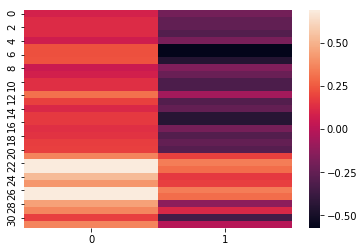

In [190]:
data = []
for row in corpus_lsi:
    row_stats = []
    for topic in row:
        row_stats.append(topic[1])
    data.append(row_stats)

seaborn_df = pd.DataFrame(data)
sns.heatmap(seaborn_df)

In [199]:
seaborn_url = 'https://seaborn.pydata.org/'
iframe = '<iframe src={} width=1000 height=300></iframe>'.format(seaborn_url)
HTML(iframe)

In [130]:
lsi.print_topics(2, num_words=5)

[(0,
  '-0.285*"increase" + -0.283*"percent" + -0.276*"rental" + -0.248*"rental_expense" + -0.236*"expense"'),
 (1,
  '0.304*"passenger" + 0.237*"service" + 0.162*"pay" + -0.161*"percent" + 0.148*"damage"')]

### LDA

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

(0.6, 0.4)
(0.1, 0.1, 0.8)
(0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution

VIDEO: https://www.hakkalabs.co/articles/the-dirichlet-distribution

Introduction to Latent Dirichlet Allocation: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [131]:
ldamodel = LdaModel(
        tfidf_corpus, num_topics=2, id2word=dictionary, passes=200)

ldamodel.print_topics(num_topics=2, num_words=5)

[(0,
  '0.023*"passenger" + 0.020*"service" + 0.018*"southwest" + 0.017*"change" + 0.016*"inspection"'),
 (1,
  '0.019*"rental" + 0.017*"increase" + 0.017*"expense" + 0.016*"landing" + 0.016*"landing_fee"')]

In [132]:
ldamodel.top_topics(corpus)

[([(0.018974580317509881, 'rental'),
   (0.017328061230754692, 'increase'),
   (0.016996578265364378, 'expense'),
   (0.01611641963098397, 'landing'),
   (0.01611641963097742, 'landing_fee'),
   (0.015348498895761549, 'percent'),
   (0.014633059876339836, 'rental_expense'),
   (0.01435251539191755, 'damage'),
   (0.013658045675954951, 'cost'),
   (0.013198770476051174, 'in'),
   (0.013004984725550211, 'airtran'),
   (0.012344643086849148, 'compare'),
   (0.012303525281150068, 'seek'),
   (0.012303525281149821, 'relief'),
   (0.01230352528114676, 'injunctive'),
   (0.01193330686936139, 'on'),
   (0.011436652843529512, 'court'),
   (0.011368825590748468, 'asm'),
   (0.01128345481733793, 'delta'),
   (0.011161364311113274, 'increase_by_million_or_percent')],
  -13.726536223002389),
 ([(0.023297363064785311, 'passenger'),
   (0.02030638240568073, 'service'),
   (0.017851455879786128, 'southwest'),
   (0.017125052016583774, 'change'),
   (0.016391845591608657, 'inspection'),
   (0.016391845

## Visdom

Install it with:

`conda install visdom`

Start the server:

`python -m visdom.server`

Visdom now can be accessed at http://localhost:8097 in the browser.


# LDA Training Visualization

Knowing about the progress and performance of a model, as we train them, could be very helpful in understanding it’s learning process and makes it easier to debug and optimize them. In this notebook, we will learn how to visualize training statistics for LDA topic model in gensim. To monitor the training, a list of Metrics is passed to the LDA function call for plotting their values live as the training progresses. 


<img src="../raw_data/images/visdom_graph.png">


SOURCE: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Training_visualizations.ipynb
Visdom SOURCE: https://github.com/facebookresearch/visdom

BLOG POST: https://rare-technologies.com/paruls-gsoc-2017-summary-training-and-topic-visualizations-in-gensim/

In [149]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

# define perplexity callback for hold_out and test corpus
#pl_holdout = PerplexityMetric(corpus=holdout_corpus, logger="visdom", title="Perplexity (hold_out)")
#pl_test = PerplexityMetric(corpus=test_corpus, logger="visdom", title="Perplexity (test)")


# u_mass, c_v, c_uci, c_npmi.
# define other remaining metrics available
ch_umass = CoherenceMetric(corpus=tfidf_corpus, coherence="c_v", logger="visdom", title="Coherence (u_mass)", window_size=110)
#ch_cv = CoherenceMetric(corpus=tfidf_corpus, texts=texts, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_kl = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [#pl_holdout, pl_test,  ch_cv,
    diff_kl, convergence_kl, ch_umass]

# training LDA model
ldamodel = LdaModel(
        tfidf_corpus, num_topics=20, id2word=dictionary, passes=200,  callbacks=callbacks)

#model = ldamodel.LdaModel(corpus=training_corpus, id2word=dictionary, num_topics=35, passes=50, chunksize=1500, iterations=200, alpha='auto', callbacks=callbacks)

ValueError: ('%s coherence is not currently supported.', 10)

### Coherence

ABSTRACT: https://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf